#### Цель
Задание — написать решение по извлечению сущностей из документов (новостных текстов). Выполните задание в Jupyter Notebook. Ожидаемый результат: ipynb-файл с решением и всеми выводами ячеек, csv-файл с предсказаниями модели залитый в репоизторий на github.

#### 1. Выбор модели 
Для решения я выбрал Blip (https://huggingface.co/docs/transformers/model_doc/blip). Причины выбора: 

1) VLM модель, то есть способна сочетать изображения и текст на входе. VLM состоит из двух основных компонентов: визуальной и текстовой моделей. Визуальная модель извлекает признаки из изображений, а текстовая модель (трансформер) обрабатывает текстовые данные. Между визуальной и текстовой моделями существует механизм взаимодействия (cross-attention), позволяющий обмениваться информацией и объединять визуальные и текстовые признаки для генерации ответа. 

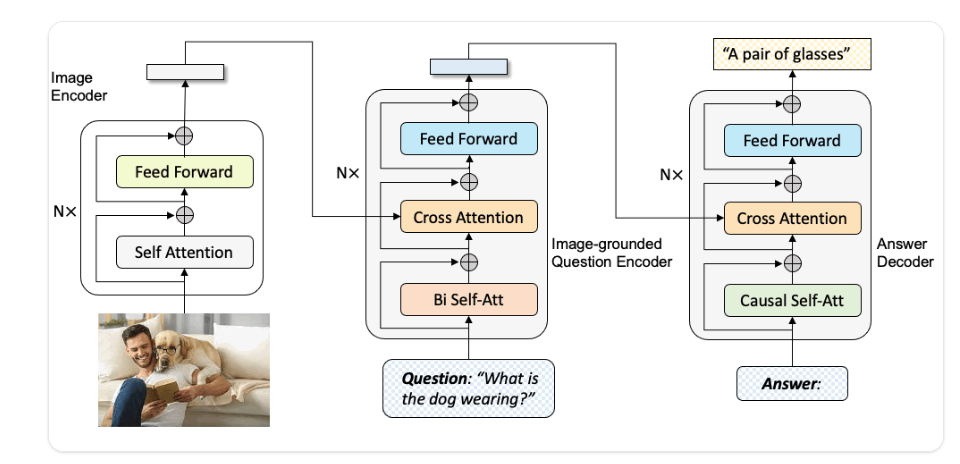

2) Не крашится на моей системе при локальном запуске и адекватно по времени работает (всего 393,225,020 параметров)

3) Обучена на широком спектре данных картинка-текст из интернета, что позволяет ей понимать общие паттерны и взаимосвязи

4) Хорошая документация, оптимизирована под быстрый инференс и доступна квантизация

#### 2. Выбор датасета 
Я выбрал датасет: ChartQA (https://paperswithcode.com/dataset/chartqa). Причины выбора:

1) Соответвует задаче chart question answering

2) Высокое качество данных и их разнообразие

3) Данные также представлены в формате пар картинка-текст как и на претрейне Blip

4) Удобство использования

#### 3. Дообучение
Для дообучения я выбрал метод LoRA (Low-Rank Adaptation). LoRA позволяет адаптировать большие модели с минимальными вычислительными затратами, что мне и нужно. Он снижает количество параметров, которые необходимо обучать, вводя низкоранговые матрицы. Целевыми модулями обучения будут слои внимания и полносвязные слои выхода. Всего обучаемых параметров будет 8,552,448 или %2.175 от общего числа.

#### 4. Выбор метрики оценки
Для такой задачи я выбрал две метрики - relaxed_correctness и accuracy.

1) accuracy - абсолютная точность предсказания, более суровая метрика, но также подходит под условия задачи из-за важности и единственности корректного ответа, потому что есть условие (картинка и вопрос), и есть только один правильный ответ

2) relaxed_correctness часто используется в научных работах (пример: https://arxiv.org/pdf/2212.09662v2) в данной сфере, хорошо сочетаясь с задачей. Она показывает почти абсолютную точность ответа, что нам и важно, но только с погрешностью 5% на численные значения

#### 5. Реализация решения:

##### Imports
Я буду использовать datasets/torch.data для данных, transformers/torch для нейронки, sklearn для метрики

In [32]:
from PIL import Image
from transformers import AutoProcessor, BlipForQuestionAnswering, Blip2Processor, Blip2ForConditionalGeneration
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

dataset = load_dataset('HuggingFaceM4/ChartQA')

c:\sber\.venv\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using the latest cached version of the dataset since HuggingFaceM4/ChartQA couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Igor\.cache\huggingface\datasets\HuggingFaceM4___chart_qa\default\0.0.0\b605b6e08b57faf4359aeb2fe6a3ca595f99b6c5 (last modified on Fri Jul 26 18:05:07 2024).


In [33]:
model

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [34]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 28299
    })
    val: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 2500
    })
})

##### Utils

In [35]:
# Создания DataLoader с батчами
# Функция обработки 
def collate_fn(batch):
    images = [item['image'] for item in batch]
    texts = [item['query'] for item in batch]
    labels = [item['label'][0] for item in batch]
    
    inputs = processor(images=images, text=texts, return_tensors="pt", padding=True, truncation=True)
    labels = processor(text=labels, return_tensors="pt", padding=True, truncation=True).input_ids

    return inputs, labels

# Беру не все данные, а только часть, чтобы ускорить обучение и оценку
train_loader = DataLoader(dataset['train'].shuffle(seed=seed).select(range(10000)), batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset['val'].shuffle(seed=seed).select(range(1000)), batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset['test'].shuffle(seed=seed).select(range(1000)), batch_size=4, shuffle=True, collate_fn=collate_fn)

# Вспомогательная функция для метрики
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Реализация relaxed_correctness с погрешностью 5%
def relaxed_correctness(predictions, references, tolerance=0.05):
    correct = 0
    total = len(references)

    for pred, ref in zip(predictions, references):
        # Проверяем, являются ли оба значения числовыми
        if is_number(pred) and is_number(ref):
            pred_num = float(pred)
            ref_num = float(ref)
            # Проверяем числовые ответы с допустимой погрешностью
            if np.abs(pred_num - ref_num) <= tolerance * np.abs(ref_num):
                correct += 1
        else:
            # Для строковых или категориальных ответов применяем точное соответствие
            if pred == ref:
                correct += 1

    return correct / total if total > 0 else 0.0

# Функция для оценки модели
def eval_model(model, return_accuracy=False, use_val_data=True):
    model.eval()
    total_loss = 0.0
    acc = 0.0
    r_c = 0.0
    data = val_loader if use_val_data else test_loader
    for batch in data: 
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        if return_accuracy:
            outputs = model.generate(**inputs, max_new_tokens=30)
            acc += np.mean(accuracy_score(processor.batch_decode(labels, skip_special_tokens=True), processor.batch_decode(outputs, skip_special_tokens=True)))
            r_c += relaxed_correctness(processor.batch_decode(labels, skip_special_tokens=True), processor.batch_decode(outputs, skip_special_tokens=True))
            
    avg_loss = total_loss / len(data)
    return (avg_loss, acc / len(data), r_c / len(data)) if return_accuracy else avg_loss

# Функция для генерация одного ответа
def generate_response(model, data):
    model.eval()
    image = data['image']
    text = data['query']
    label = data['label'][0]
    inputs = processor(images=image, text=text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs)
    print(f'Query: {text}')
    print(f'True label: {label}')
    plt.imshow(image)
    print(f'\nPredicted response: {processor.batch_decode(outputs, skip_special_tokens=True)[0]}')
        
    

Query: What's the color of graph with 56 as the highest value?
True label: Blue

Predicted response: green


c:\sber\.venv\Lib\site-packages\transformers\generation\utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


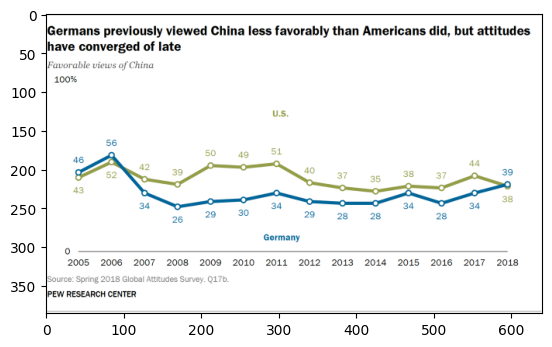

In [36]:
generate_response(model, dataset['val'][0])

In [14]:
loss, accuracy, relaxed_corr = eval_model(model, return_accuracy=True, use_val_data=False)
print(f'Blip base model test loss: {loss:.4f}, Blip base model test accuracy: {accuracy:.4f}, Blip base model relaxed correctness: {relaxed_corr:.4f}')

Blip base model test loss: 6.5531, Blip base model test accuracy: 0.0350, Blip base model relaxed correctness: 0.0870


##### Дообучение

In [37]:
from peft import get_peft_model, LoraConfig

# Создание Lora модели из конфига
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "self.query",
        "self.key",
        "self.value",
        "output.dense",
        "self_attn.qkv",
        "self_attn.projection",
        "mlp.fc1",
        "mlp.fc2",
    ],
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 8,552,448 || all params: 393,225,020 || trainable%: 2.1750


In [38]:
model

PeftModel(
  (base_model): LoraModel(
    (model): BlipForQuestionAnswering(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=2304, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=2304, bias=False)
                  )
  

In [5]:
import torch.optim as optim

# Обучаем модель 10 эпох
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    val_loss = eval_model(model)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/10, Train Loss: 6.0360, Val Loss: 5.6725
Epoch 2/10, Train Loss: 5.3390, Val Loss: 5.0899
Epoch 3/10, Train Loss: 5.1304, Val Loss: 5.0229
Epoch 4/10, Train Loss: 4.9934, Val Loss: 5.0489
Epoch 5/10, Train Loss: 4.8563, Val Loss: 5.1226
Epoch 6/10, Train Loss: 4.7484, Val Loss: 5.1485
Epoch 7/10, Train Loss: 4.6464, Val Loss: 5.1524
Epoch 8/10, Train Loss: 4.5549, Val Loss: 5.2316
Epoch 9/10, Train Loss: 4.4578, Val Loss: 5.1787
Epoch 10/10, Train Loss: 4.3850, Val Loss: 5.2670


In [6]:
model.save_pretrained('lora10')

In [12]:
loss, accuracy, relaxed_corr = eval_model(model, return_accuracy=True, use_val_data=False)
print(f'Lora fine-tuned model test loss: {loss:.4f}, Lora fine-tuned model test accuracy: {accuracy:.4f}, Lora fine-tuned model relaxed correctness: {relaxed_corr:.4f}')

Lora fine-tuned model test loss: 5.0962, Lora fine-tuned model test accuracy: 0.1430, Lora fine-tuned model relaxed correctness: 0.2240


##### Создание csv файла, где будут target и predicted значения.

In [29]:
preds = list()
true_labels = list()
for batch in test_loader: 
    inputs, labels = batch
    inputs = {k: v.to(device) for k, v in inputs.items()}
    labels = labels.to(device)
    outputs = model.generate(**inputs, max_new_tokens=30)
    preds.extend(processor.batch_decode(labels, skip_special_tokens=True))
    true_labels.extend(processor.batch_decode(outputs, skip_special_tokens=True))

In [30]:
import pandas as pd
result = pd.DataFrame({'True Labels': true_labels, 'Predicted': preds})
result

,True Labels,Predicted
0,united states,france
1,4. 3,4. 9
2,1055,1055
3,18. 29,12. 99
4,2. 84,2. 76
...,...,...
995,3697,9562
996,0. 8387,2. 2258
997,2010,2017
998,41. 78,41. 78


In [31]:
result.to_csv('predictions.csv', index=False)

#### Вывод: 
Использование метода LoRA для дообучения модели BLIP привело к значительному улучшению показателей:

1) Test Loss уменьшился с 6.5531 до 5.0962, что свидетельствует о лучшем качестве предсказаний

2) Test Accuracy увеличилась с 0.0350 до 0.1430

3) Relaxed Correctness выросла с 0.0870 до 0.2240

Увеличение эпох обучение приводит к переобучению. Локальной системы не хватает чтобы увеличить число данных или число параметров обучения. В целом результат положительный. 
